In [90]:
import pandas_ta as ta
import pandas as pd
import numpy as np
from datetime import datetime
import main_functions
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
# from lightweight_charts import Chart
# from lightweight_charts.widgets import JupyterChart
# import mplfinance as mpf
# import yfinance as yf

In [91]:
import importlib
# If you want to update the module:
importlib.reload(main_functions)
from main_functions import *

In [92]:
# Initialize notebook mode
init_notebook_mode(connected=True)

In [93]:
pd.set_option('display.max_rows', 400)  # Set the maximum number of rows to display

# Defining the variables

In [94]:
ticker = "BTCUSDT"
timeframe = "1d"
start = "2017-01-01"
start_date = datetime.strptime(start, "%Y-%m-%d")
end = str(datetime.now())
# Calculate the difference in days
day = (datetime.now() - start_date).days

In [95]:
df = getdata(ticker, timeframe, day)

In [96]:
df['candle_type'] = np.where(
    (df['High'] > df['High'].shift(1)) &
    (df['Low'] > df['Low'].shift(1)),
    "up_bar",
    np.where(
        (df['High'] < df['High'].shift(1)) &
        (df['Low'] < df['Low'].shift(1)),
        "down_bar",
        np.where(
            (df['High'] > df['High'].shift(1)) &
            (df['Low'] < df['Low'].shift(1)) &
            (df['Open'] > df['Close']),
            "outside_up_dn",
            np.where(
                (df['High'] > df['High'].shift(1)) &
                (df['Low'] < df['Low'].shift(1)) &
                (df['Open'] < df['Close']),
                "outside_dn_up",
                ""
            )
        )
    )
)


In [97]:
# def f_sw_inc_cnt(p_cnt, p_max_cnt):
#     new_cnt = p_cnt
    
#     if p_cnt < 0:
#         new_cnt = 1
#     else:
#         if p_cnt + 1 > p_max_cnt:
#             new_cnt = p_max_cnt
#         else:
#             new_cnt = p_cnt + 1
            
#     return new_cnt


In [98]:
# Create the 'p_cnt' column with a default value (0)
# df['p_cnt'] = 0
# df["sw_cnt"] = 0
# df["p_cnt"] = np.where(df['candle_type'] == "up_bar", df.apply(lambda row: f_sw_inc_cnt(row['p_cnt'], 3), axis=1), 0)
# df["sw_cnt"] = np.where(df['candle_type'] == "up_bar", df.apply(lambda row: f_sw_inc_cnt(row['p_cnt'], 3), axis=1), 0)
# # df = df.drop(columns=['sw_top_index'])
# df

In [99]:
# Initialize p_cnt with a list containing the initial value (0) for the first row
p_cnt_values = [0]

# Define the maximum value that sw_cnt can take
max_sw_cnt = 3

# Iterate over the rows of the DataFrame starting from the second row (index 1)
for i in range(1, len(df)):
    # Get the current candlestick type for the current row
    current_candle_type = df['candle_type'].iloc[i]
    
    # Get the previous sw_cnt value (p_cnt) for the current row
    previous_sw_cnt = p_cnt_values[i - 1]
    
    # Initialize a variable to store the new sw_cnt value
    new_sw_cnt = None
    
    # Check various conditions to determine the new sw_cnt value
    if (current_candle_type == "up_bar" and previous_sw_cnt < 0) or (current_candle_type == "outside_dn_up" and previous_sw_cnt < 0):
        new_sw_cnt = 1
    elif current_candle_type == "up_bar" and previous_sw_cnt < max_sw_cnt:
        new_sw_cnt = previous_sw_cnt + 1
    elif current_candle_type == "up_bar" and previous_sw_cnt == max_sw_cnt:
        new_sw_cnt = max_sw_cnt
    elif (current_candle_type == "down_bar" and previous_sw_cnt > 0) or (current_candle_type == "outside_up_dn" and previous_sw_cnt > 0):
        new_sw_cnt = -1
    elif current_candle_type == "down_bar" and previous_sw_cnt > -max_sw_cnt:
        new_sw_cnt = previous_sw_cnt - 1
    elif current_candle_type == "down_bar" and previous_sw_cnt == -max_sw_cnt:
        new_sw_cnt = -max_sw_cnt
    elif current_candle_type == "outside_dn_up" and previous_sw_cnt > 0:
        new_sw_cnt = previous_sw_cnt
    elif current_candle_type == "outside_up_dn" and previous_sw_cnt < 0:
        new_sw_cnt = previous_sw_cnt
    else:
        # If none of the conditions are met, keep the sw_cnt unchanged
        new_sw_cnt = previous_sw_cnt
    
    # Append the new sw_cnt value to the list of sw_cnt values
    p_cnt_values.append(new_sw_cnt)

# Check if the length of sw_cnt values matches the number of rows in df
if len(p_cnt_values) == len(df):
    # Assign the list of sw_cnt values to a new column 'sw_cnt' in df
    df['sw_cnt'] = p_cnt_values
else:
    print("Length mismatch error between p_cnt_values and df.")

# Print the length of sw_cnt values and the number of rows in df for verification
print("Length of sw_cnt values:", len(p_cnt_values))
print("Number of rows in df:", len(df))

Length of sw_cnt values: 1478
Number of rows in df: 1478


In [100]:
# Initialize sw_trend with NaN
df['sw_trend'] = np.nan

# Create mask1 and mask2
mask1 = (
    ((df['sw_cnt'] == -3) | 
    ((df['sw_cnt'] == 1) & (df['candle_type'] == 'outside_dn_up'))) &
    (df['sw_cnt'].shift(1) == -2) # & (df['sw_trend'].shift(1) != df['sw_trend'])
)

mask2 = (
    ((df['sw_cnt'] == 3) | 
    ((df['sw_cnt'] == -1) & (df['candle_type'] == 'outside_up_dn'))) &
    (df['sw_cnt'].shift(1) == 2) # & (df['sw_trend'].shift(1) != df['sw_trend'])
)

# Update sw_trend based on mask1 and mask2
df.loc[mask1, 'sw_trend'] = -1
df.loc[mask2, 'sw_trend'] = 1

# Forward fill the sw_trend column to carry forward the last value
df['sw_trend'].ffill(inplace=True)
df.head(150)

,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend
timestamp,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,,0,NaN
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,up_bar,1,NaN
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,down_bar,-1,NaN
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,down_bar,-2,NaN
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,up_bar,1,NaN
2019-09-13,10414.96,10440.55,10153.51,10341.34,19252.721,,1,NaN
2019-09-14,10343.01,10419.97,10222.77,10332.25,20656.624,,1,NaN
2019-09-15,10333.47,10359.20,10024.81,10302.22,20536.255,down_bar,-1,NaN
2019-09-16,10302.00,10353.81,10080.70,10249.27,20185.637,,-1,NaN


In [101]:
trend_cnt = [0]

# Loop through the DataFrame index
for i in range(1, len(df)):
    if df['sw_trend'].iloc[i-1] == df['sw_trend'].iloc[i]:
        trend_cnt.append(trend_cnt[i-1] + 1)
    else:
        trend_cnt.append(1)
# Append a 0 at the beginning to match the length of the DataFrame
trend_cnt.insert(0, 0)
        
df['trend_cnt'] = trend_cnt[:-1]

df.head(200)

,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt
timestamp,,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,,0,NaN,0
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,up_bar,1,NaN,0
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,down_bar,-1,NaN,1
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,down_bar,-2,NaN,1
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,up_bar,1,NaN,1
2019-09-13,10414.96,10440.55,10153.51,10341.34,19252.721,,1,NaN,1
2019-09-14,10343.01,10419.97,10222.77,10332.25,20656.624,,1,NaN,1
2019-09-15,10333.47,10359.20,10024.81,10302.22,20536.255,down_bar,-1,NaN,1
2019-09-16,10302.00,10353.81,10080.70,10249.27,20185.637,,-1,NaN,1


In [102]:
# Initialize sw_top column with False
df['sw_top'] = False
df['sw_bottom'] = False

# Create mask1 and mask2
# mask1 = ((df['sw_cnt'] == -3) & (df['sw_cnt'].shift(1) == -2) & (df['sw_trend'].shift(1) != df['sw_trend']))
# mask2 = ((df['sw_cnt'] == 3) & (df['sw_cnt'].shift(1) == 2) & (df['sw_trend'].shift(1) != df['sw_trend']))
# Calculate the maximum High value of past n candles when mask1 is true
for i in range(len(df)):
    if mask1[i]:
        # Calculate the maximum High and its index
        high_range = df.loc[df.index[max(0, i - int(df['trend_cnt'][i]))]:df.index[i]]['High']
        max_high = high_range.max()
        max_high_index = high_range.idxmax()
        
        # Mark the row where max_high occurs as True 
        df.at[max_high_index, 'sw_top'] = True
        
    elif mask2[i]:
        # Calculate the maximum High and its index
        low_range = df.loc[df.index[max(0, i - int(df['trend_cnt'][i]))]:df.index[i]]['Low']
        min_low = low_range.min()
        min_low_index = low_range.idxmin()
        
        # Mark the row where max_high occurs as True
        df.at[min_low_index, 'sw_bottom'] = True

df['sw_high_price'] = np.where(df['sw_top'] == True, df['High'], np.nan)
df['sw_high_price'].fillna(method='ffill', inplace=True)
df['sw_low_price'] = np.where(df['sw_bottom'] == True, df['Low'], np.nan)
df['sw_low_price'].fillna(method='ffill', inplace=True)
        
df.head(200)

,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt,sw_top,sw_bottom,sw_high_price,sw_low_price
timestamp,,,,,,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,,0,NaN,0,False,False,NaN,NaN
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,up_bar,1,NaN,0,False,False,NaN,NaN
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,down_bar,-1,NaN,1,False,False,NaN,NaN
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,down_bar,-2,NaN,1,False,False,NaN,NaN
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,up_bar,1,NaN,1,False,False,NaN,NaN
2019-09-13,10414.96,10440.55,10153.51,10341.34,19252.721,,1,NaN,1,False,False,NaN,NaN
2019-09-14,10343.01,10419.97,10222.77,10332.25,20656.624,,1,NaN,1,False,False,NaN,NaN
2019-09-15,10333.47,10359.20,10024.81,10302.22,20536.255,down_bar,-1,NaN,1,False,False,NaN,NaN
2019-09-16,10302.00,10353.81,10080.70,10249.27,20185.637,,-1,NaN,1,False,False,NaN,NaN


In [103]:
# Filter rows where sw_top is True and calculate sw_highs
df_tops = df[df['sw_top'] == True].copy()
df_tops['sw_highs'] = np.where(df_tops['High'] > df_tops['High'].shift(1), "HH", "LH")

# Filter rows where sw_bottom is True and calculate sw_lows
df_bottoms = df[df['sw_bottom'] == True].copy()
df_bottoms['sw_lows'] = np.where(df_bottoms['Low'] < df_bottoms['Low'].shift(1), "LL", "HL")

# Concatenate the DataFrames and select the desired columns
df_swings = pd.concat([df_tops, df_bottoms], axis=1)

df_swings['trend'] = np.nan
df_swings['trend'] = np.where(((df_swings['sw_highs'] == 'HH') & (df_swings['sw_lows'].shift(1) == 'HL')) |
                              ((df_swings['sw_lows'] == 'HL') & (df_swings['sw_highs'].shift(1) == 'HH')),
                               "UP",
                               np.where(((df_swings['sw_lows'] == 'LL') & (df_swings['sw_highs'].shift(1) == 'LH')) |
                                        ((df_swings['sw_highs'] == 'LH') & (df_swings['sw_lows'].shift(1) == 'LL')),
                                        "DOWN",
                                        np.where(((df_swings['sw_lows'] == 'LL') & (df_swings['sw_highs'].shift(1) == 'HL')) | 
                                                 ((df_swings['sw_lows'] == 'LL') & (df_swings['sw_highs'].shift(1) == 'HH')) |
                                                 ((df_swings['sw_lows'] == 'HL') & (df_swings['sw_highs'].shift(1) == 'LH')) |
                                                 ((df_swings['sw_highs'] == 'LH') & (df_swings['sw_lows'].shift(1) == 'HL')) |
                                                 ((df_swings['sw_highs'] == 'HH') & (df_swings['sw_lows'].shift(1) == 'LL')),
                                                 "UNCERTAIN",
                                                 np.nan
                                                )
                                             )
                                         )


df_swings = df_swings[["sw_highs", "sw_lows","trend"]]
df_swings

,sw_highs,sw_lows,trend
timestamp,,,
2019-09-19,LH,NaN,nan
2019-09-26,NaN,HL,UNCERTAIN
2019-10-11,LH,NaN,UNCERTAIN
2019-10-23,NaN,LL,DOWN
2019-10-28,HH,NaN,UNCERTAIN
2019-11-14,LH,NaN,nan
2019-12-18,NaN,LL,DOWN
2019-12-23,LH,NaN,DOWN
2020-01-03,NaN,HL,UNCERTAIN


In [104]:
df_ffill = pd.concat([df, df_swings], axis=1)

# Define the columns to be copied
columns_to_copy = ["sw_highs", "sw_lows", "trend"]

# Forward fill columns in df_ffill
df_ffill[columns_to_copy] = df_ffill[columns_to_copy].fillna(method='ffill')

# Drop the columns to be replaced from df
for column in columns_to_copy:
    if column in df.columns:
        df.drop(columns=column, inplace=True)

# Update the original DataFrame with the filled columns
df = pd.concat([df, df_ffill[columns_to_copy]], axis=1)

# Display the DataFrame
df.head(200)


,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt,sw_top,sw_bottom,sw_high_price,sw_low_price,sw_highs,sw_lows,trend
timestamp,,,,,,,,,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,,0,NaN,0,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,up_bar,1,NaN,0,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,down_bar,-1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,down_bar,-2,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,up_bar,1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-13,10414.96,10440.55,10153.51,10341.34,19252.721,,1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-14,10343.01,10419.97,10222.77,10332.25,20656.624,,1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-15,10333.47,10359.20,10024.81,10302.22,20536.255,down_bar,-1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN
2019-09-16,10302.00,10353.81,10080.70,10249.27,20185.637,,-1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN


In [105]:
df["LONG_Signal"] = np.where((df['sw_lows'] == "HL") & 
                             (df['High'] > df['sw_high_price'].shift(1)) &
                             (df['High'].shift(1) < df['sw_high_price']) &
                             (df['trend'].shift(1) == "UNCERTAIN"), 
                             True, 
                             False)

df["SHORT_Signal"] = np.where((df['sw_highs'] == "LH") & 
                              (df['Low'] < df['sw_low_price'].shift(1)) &
                              (df['Low'].shift(1) > df['sw_low_price']) &
                              (df['trend'].shift(1) == "UNCERTAIN"),  
                              True, 
                              False)

df.head(200)

,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt,sw_top,sw_bottom,sw_high_price,sw_low_price,sw_highs,sw_lows,trend,LONG_Signal,SHORT_Signal
timestamp,,,,,,,,,,,,,,,,,,
2019-09-08,10000.00,10412.65,10000.00,10391.63,3096.291,,0,NaN,0,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-09,10316.62,10475.54,10077.22,10307.00,14824.373,up_bar,1,NaN,0,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-10,10307.00,10382.97,9940.87,10102.02,9068.955,down_bar,-1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-11,10094.27,10293.11,9884.31,10159.55,10897.922,down_bar,-2,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-12,10163.06,10450.13,10042.12,10415.13,15609.634,up_bar,1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-13,10414.96,10440.55,10153.51,10341.34,19252.721,,1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-14,10343.01,10419.97,10222.77,10332.25,20656.624,,1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-15,10333.47,10359.20,10024.81,10302.22,20536.255,down_bar,-1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN,False,False
2019-09-16,10302.00,10353.81,10080.70,10249.27,20185.637,,-1,NaN,1,False,False,NaN,NaN,NaN,NaN,NaN,False,False


In [106]:
df[df['LONG_Signal'] == True]

,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt,sw_top,sw_bottom,sw_high_price,sw_low_price,sw_highs,sw_lows,trend,LONG_Signal,SHORT_Signal
timestamp,,,,,,,,,,,,,,,,,,
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,up_bar,3,1.0,4,False,True,7691.00,7345.00,LH,HL,nan,True,False
2020-04-02,6641.22,7290.00,6542.73,6791.63,531321.428,up_bar,2,-1.0,4,False,False,6960.71,5850.00,LH,HL,UNCERTAIN,True,False
2020-04-06,6768.90,7370.00,6760.00,7325.73,461331.013,up_bar,3,1.0,8,False,False,6960.71,5850.00,LH,HL,UNCERTAIN,True,False
2020-04-12,6874.17,7173.98,6775.66,6900.52,321594.822,up_bar,1,1.0,6,False,False,6960.71,5850.00,LH,HL,UNCERTAIN,True,False
2020-04-14,6834.01,6975.60,6751.00,6864.11,280445.427,up_bar,1,1.0,8,False,False,6960.71,5850.00,LH,HL,UNCERTAIN,True,False
2020-04-16,6616.88,7190.92,6465.33,7098.15,559868.603,outside_dn_up,1,1.0,10,False,True,6960.71,6465.33,LH,HL,nan,True,False
2020-07-22,9388.00,9543.00,9272.00,9518.25,126598.902,up_bar,3,1.0,10,False,True,9470.00,9272.00,LH,HL,nan,True,False
2021-06-14,38993.66,41000.00,38720.00,40489.10,704979.881,up_bar,2,-1.0,6,False,False,39470.00,30969.00,LH,HL,UNCERTAIN,True,False
2021-06-15,40489.10,41413.00,39500.00,40132.86,632066.994,up_bar,3,1.0,7,True,False,41413.00,30969.00,HH,HL,UP,True,False


In [107]:
df[df['SHORT_Signal'] == True]

,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt,sw_top,sw_bottom,sw_high_price,sw_low_price,sw_highs,sw_lows,trend,LONG_Signal,SHORT_Signal
timestamp,,,,,,,,,,,,,,,,,,
2019-10-23,8020.68,8047.78,7172.76,7465.00,108484.139,down_bar,-2,-1.0,5,False,True,8788.00,7172.76,LH,LL,DOWN,False,True
2020-03-08,8895.62,8897.71,7997.70,8038.46,237407.028,down_bar,-2,1.0,2,False,False,9204.00,8409.00,LH,HL,UNCERTAIN,False,True
2020-03-13,4762.28,5971.00,3621.81,5570.26,935489.242,down_bar,-3,-1.0,4,False,True,9204.00,3621.81,LH,LL,DOWN,False,True
2020-09-03,11396.44,11475.00,9901.16,10141.08,487812.737,down_bar,-2,1.0,3,False,False,12061.07,11130.00,LH,HL,UNCERTAIN,False,True
2020-09-05,10448.00,10567.87,9808.58,10168.71,399307.282,down_bar,-3,-1.0,1,False,True,12061.07,9808.58,LH,LL,DOWN,False,True
2021-05-12,56712.70,58049.99,48503.74,49595.76,472329.152,outside_up_dn,-1,1.0,14,False,False,59654.00,52350.00,LH,HL,UNCERTAIN,False,True
2021-07-20,30823.62,31050.00,29242.24,29775.90,602688.190,down_bar,-2,-1.0,6,False,True,36623.00,29242.24,LH,LL,DOWN,False,True
2022-06-12,28416.60,28530.30,26538.70,26564.70,560834.131,down_bar,-3,-1.0,1,False,False,32427.50,27952.10,LH,HL,UNCERTAIN,False,True
2022-06-18,20457.30,20768.40,17593.20,18959.70,1268591.388,down_bar,-1,-1.0,7,False,True,32427.50,17593.20,LH,LL,DOWN,False,True


# Backtest

In [108]:
# def getSignals(df, **kwargs):
# #     df = getdata(ticker)

#     # Extract the parameter values from the kwargs dictionary
#     mult = kwargs.get('mult', 1)
#     HL = kwargs.get('HL', 20)
#     risk = kwargs.get('risk', 15)
    
#     df = pd.concat((df,ta.ha(df.Open, df.High, df.Low, df.Close)), axis = 1)
#     df= df.astype(float)
#     df['MinLow'] = df['HA_low'].shift(1).rolling(HL).min()
#     df['MaxHigh'] = df['HA_high'].shift(1).rolling(HL).max()
#     df['shifted_open'] = df.Open.shift(-1)
#     df['buyrisk'] = (df['Close'] - df['MinLow'])/df['Close'] 
#     df['sellrisk'] = (df['MaxHigh'] - df['Close'])/df['Close']
#     df['longTP'] = ((df.Close - df.MinLow) * mult) + df.Close
#     df['shortTP'] = df.Close - ((df.MaxHigh - df.Close) * mult)
#     # Apply the conditions for buySignal
#     df['buySignal'] = np.where(
#                         (df['HA_close'].shift(1) < df['HA_open'].shift(1)) &
#                         (df['HA_low'] == df['HA_open']) &
#                         (df['HA_low'].shift(1) == df['MinLow']) &
#                         (takeLong == True) &
#                         (df['buyrisk'] < risk/100),
#                         1,
#                         0
#     )
#     df['shortSignal'] = np.where(
#                     (df['HA_close'].shift(1) > df['HA_open'].shift(1)) &
#                     (df['HA_high'] == df['HA_open']) &
#                     (df['HA_high'].shift(1) == df['MaxHigh']) &
#                     (takeShort == True) &
#                     (df['sellrisk'] < risk/100),
#                     -1,
#                     0
#     )
#     return df

# Trades Display

def displayTrades():
    ct = min(len(buydates),len(selldates))
    dfr =pd.DataFrame()
    dfr['buydates']= buydates[:ct]
    dfr['buyprice']= buyprices[:ct]
    dfr['selldates'] = selldates[:ct]
    dfr['sellprice'] = sellprices[:ct]
    dfr['profits'] = (profits[:ct])
    dfr['commulative_returns'] = ((pd.Series(profits) + 1).cumprod())
    dfr['tradeSide'] = np.where(dfr['buydates'] < dfr['selldates'], 'Long', 'Short')
    return dfr

# df = getSignals(df)

In [113]:
commission = 0.04/100

in_position = False
buy_pos = False
sell_pos = False

results_df = pd.DataFrame()
buydates, buyprices = [],[]
selldates, sellprices = [],[]
df['tsl_long'] = df['sw_low_price'].shift(1)
df['tsl_short'] = df['sw_high_price'].shift(1)

for index, row in df.iterrows():
# ---------------------------------------------long position block------------------------------
    if in_position and buy_pos:
        sl = row.tsl_long
        if (row.Low <= sl):
            selldates.append(index)
            sellprices.append(sl)
            in_position = False
            buy_pos = False
#         elif in_position and (row.High >= tp):
#             selldates.append(index)
#             sellprices.append(tp)
#             in_position = False
#             buy_pos = False

    elif not in_position and row.LONG_Signal == True:
        buyprice = row.tsl_long
        buydates.append(index)
        buyprices.append(buyprice)
        in_position = True
        buy_pos = True
#         tp = row.longTP

# --------------------------------------------short position block-------------------------------
    elif in_position and sell_pos:
        sl = row.tsl_short
        if (row.High >= sl):
            buydates.append(index)
            buyprices.append(sl)
            in_position = False
            sell_pos = False
        
    elif not in_position and row.SHORT_Signal == True:
        sellprice = row.tsl_short
        selldates.append(index)
        sellprices.append(sellprice)
        in_position = True
        sell_pos = True

#         elif in_position and (row.Low <= tp):
#             buydates.append(index)
#             buyprices.append(tp)
#             in_position = False
#             sell_pos = False


# try:
if len(buydates) == 0:
    print("No trades were made.")
else:
    profits = [(sell - buy)/buy - commission for sell,buy in zip(sellprices, buyprices)]
    returns = ((pd.Series(profits, dtype=float) + 1).prod()-1)*100
    wins = 0
    for i in profits:
        if i > 0:
            wins+=1
        i+=1
    winrate = round((wins/len(buydates))*100,2)
    ct = min(len(buydates),len(selldates))
    # BTCUSDT buy and hold returns during the same period

    buy_hold_ret = (df['Close'][-1]-df['Open'][0])/df['Open'][0] *100
    results_df = pd.concat([results_df, pd.DataFrame({'ticker': f'{ticker}', 'returns': [returns], 'winrate': [winrate], 'trades':[ct], 'buy&hold_ret%' : [buy_hold_ret]})])#, 'mult' : [mult], 'No. of H/L previous Candles':[HL], 'Max Risk%':[risk]})])
    print(f'{ticker}, winrate={winrate}%, returns={round(returns,2)}%, no. of trades = {ct}, buy&hold_ret = {round(buy_hold_ret,2)}%')#, mult = {mult}, No. of H/L previous Candles : {HL}, Max Risk% : {risk}')
# except:
#     print(f'Invalid input')

BTCUSDT, winrate=50.0%, returns=680.37%, no. of trades = 14, buy&hold_ret = 164.61%


In [114]:
results_df

,ticker,returns,winrate,trades,buy&hold_ret%
0,BTCUSDT,680.374292,50.0,14,164.611


In [115]:
dfr = displayTrades()
dfr

,buydates,buyprice,selldates,sellprice,profits,commulative_returns,tradeSide
0,2019-10-25,8788.00,2019-10-23,8788.00,-0.000400,0.999600,Short
1,2020-01-06,6863.44,2020-03-08,8409.00,0.224787,1.224297,Long
2,2020-04-02,6960.71,2020-03-13,9204.00,0.321879,1.618373,Short
3,2020-04-06,5850.00,2020-09-03,11130.00,0.902164,3.078411,Long
4,2020-10-10,11177.00,2020-09-05,12061.07,0.078697,3.320673,Short
5,2021-06-14,39470.00,2021-05-12,59654.00,0.510976,5.017457,Short
6,2021-06-15,30969.00,2021-06-22,30969.00,-0.000400,5.015450,Long
7,2021-07-26,36623.00,2021-07-20,36623.00,-0.000400,5.013444,Short
8,2022-03-22,40430.00,2022-04-11,40430.00,-0.000400,5.011438,Long
9,2022-07-08,21888.00,2022-06-12,32427.50,0.481120,7.422540,Short


## CANDLES CHART

In [116]:
long_signals = df[df['LONG_Signal']]
long_signals.index

DatetimeIndex(['2020-01-06', '2020-04-02', '2020-04-06', '2020-04-12',
               '2020-04-14', '2020-04-16', '2020-07-22', '2021-06-14',
               '2021-06-15', '2022-03-22', '2022-03-28', '2022-10-25',
               '2022-10-29', '2023-02-15', '2023-02-21'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [117]:
for _, row in dfr.iterrows():
    print('Buy Dates: ', row['buydates'])
    print('Sell Dates: ', row['selldates'])

Buy Dates:  2019-10-25 00:00:00
Sell Dates:  2019-10-23 00:00:00
Buy Dates:  2020-01-06 00:00:00
Sell Dates:  2020-03-08 00:00:00
Buy Dates:  2020-04-02 00:00:00
Sell Dates:  2020-03-13 00:00:00
Buy Dates:  2020-04-06 00:00:00
Sell Dates:  2020-09-03 00:00:00
Buy Dates:  2020-10-10 00:00:00
Sell Dates:  2020-09-05 00:00:00
Buy Dates:  2021-06-14 00:00:00
Sell Dates:  2021-05-12 00:00:00
Buy Dates:  2021-06-15 00:00:00
Sell Dates:  2021-06-22 00:00:00
Buy Dates:  2021-07-26 00:00:00
Sell Dates:  2021-07-20 00:00:00
Buy Dates:  2022-03-22 00:00:00
Sell Dates:  2022-04-11 00:00:00
Buy Dates:  2022-07-08 00:00:00
Sell Dates:  2022-06-12 00:00:00
Buy Dates:  2022-09-11 00:00:00
Sell Dates:  2022-09-07 00:00:00
Buy Dates:  2022-10-25 00:00:00
Sell Dates:  2022-11-08 00:00:00
Buy Dates:  2023-02-15 00:00:00
Sell Dates:  2023-03-09 00:00:00
Buy Dates:  2023-06-21 00:00:00
Sell Dates:  2023-05-08 00:00:00


In [118]:
# Create a candlestick trace
candlestick = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    name='Candles',
)

# Create text annotations for sw_cnt on top of each candle
annotations = []

# Create sw_top marker trace
sw_top_markers = create_marker_trace(df, 'sw_top', 'triangle-up', 'High', 500, 'Top', 'Trend Peaks', 'green')

# Create sw_bottom marker trace
sw_bottom_markers = create_marker_trace(df, 'sw_bottom', 'triangle-down', 'Low', -500, 'Bottom', 'Trend Bottoms', 'red')

# Define colors for each trend type
bg_colors = {
    'UP': 'green',
    'DOWN': 'red',
    'UNCERTAIN': 'yellow'
}

opacity_up = 0.2
opacity_down = 0.15
opacity_uncertain = 0.15

# Create background shapes based on the "trend" column
background_shapes = create_background_shapes(df, 'trend', bg_colors)

# Create the layout with a white background and the background shapes
layout = go.Layout(
    shapes=background_shapes,
    showlegend=False,
    # xaxis=dict(showgrid=True, gridcolor='black'),  # Set gridcolor to 'black' for x-axis
    # yaxis=dict(showgrid=True, gridcolor='black'),  # Set gridcolor to 'black' for y-axis
    # plot_bgcolor='white'
)

# Define a button to toggle the visibility of background traces
toggle_button = dict(
    type="buttons",
    showactive=False,
    buttons=[
        dict(label="Show Background Traces",
             method="relayout",
             args=["shapes", background_shapes]),
        dict(label="Hide Background Traces",
             method="relayout",
             args=["shapes", []]),  # Empty list to hide the shapes
    ],
    x=1.15,  # Adjust the x position to move the button to the right
    y=0.15,   # Adjust the y position to place it below the legends
)
layout["updatemenus"] = [toggle_button]

# Define colors for uptrend and downtrend zig zag lines
uptrend_color = 'green'
downtrend_color = 'red'

# Create the zigzag trace
zigzag_trace = create_zigzag_trace(df, 'sw_top', 'sw_bottom', uptrend_color, downtrend_color)

# Create the figure with the candlestick trace and markers (both top and bottom)
fig = go.Figure(data=[candlestick, sw_top_markers, sw_bottom_markers, zigzag_trace], layout=layout)

# Define parameters for each label
label_params = {
    'HH': {'color': 'green', 'textposition': 'bottom center'},
    'LH': {'color': 'red', 'textposition': 'bottom center'},
    'LL': {'color': 'blue', 'textposition': 'top center'},
    'HL': {'color': 'purple', 'textposition': 'top center'},
}

plot_labels(df, label_params, fig)

# Plot the Long signals as green arrows
long_signals = df[df['LONG_Signal']]
fig.add_trace(go.Scatter(
    x=long_signals.index,
    y=df['sw_high_price'][long_signals.index],
    mode='markers',
    marker=dict(
        symbol='arrow-bar-right',
        size=20,
        color='green',
    ),
    name='Long Signals',
))

# Plot the Short signals as red arrows
short_signals = df[df['SHORT_Signal']]
fig.add_trace(go.Scatter(
    x=short_signals.index,
    y=df['sw_low_price'][short_signals.index],
    mode='markers',
    marker=dict(
        symbol='arrow-bar-right',
        size=20,
        color='red',
    ),
    name='Short Signals',
))


# Plot the trailing stop loss levels for each trade
for _, row in dfr.iterrows():  # Use "_" to indicate that we don't need the index
    if row['tradeSide'] == 'Long':
        tsl = df.loc[row.iloc[0], 'sw_low_price']  # Stop loss for Long position from df
        name = 'Long Trailing Stop Loss'
        color = 'red'
        entry_label = 'LONG ENTRY'
    else:
        tsl = df.loc[row.iloc[0], 'sw_high_price']  # Stop loss for Short position from df
        name = 'Short Trailing Stop Loss'
        color = 'blue'
        entry_label = 'SHORT ENTRY'

    # Set the condition for y values based on tradeSide
    if row['tradeSide'] == 'Long':
        x_values = [row['buydates'], row['selldates'], row['selldates'], row['buydates']]
        y_values = [row['buyprice'], row['buyprice'], tsl, tsl]
        fillcolor = 'rgba(255, 0, 0, 0.3)'  # Red fill for Long
    else:
        x_values = [row['selldates'], row['buydates'], row['buydates'], row['selldates']]
        y_values = [row['sellprice'], row['sellprice'], tsl, tsl]
        fillcolor = 'rgba(255, 0, 0, 0.3)'  # Red fill for Short

    fig.add_trace(go.Scatter(
        x=x_values,
        y=y_values,
        fill='toself',
        fillcolor=fillcolor,
        name=name,
        mode='none',
        showlegend=False  # Exclude legend for this trace
    ))
    # Set the condition for y values based on tradeSide
    entry_exit_data = {
        'Long': {
            'xx_values': [row['buydates'], row['selldates']],
            'yy_values': [row['buyprice'] + 500, tsl],
        },
        'Short': {
            'xx_values': [row['selldates'], row['buydates']],
            'yy_values': [row['sellprice'] - 500, tsl],
        },
    }

    data = entry_exit_data.get(row['tradeSide'])

    if data:
        xx_values = data['xx_values']
        yy_values = data['yy_values']
        
        # Add labels for LONG ENTRY and SHORT ENTRY
        fig.add_trace(go.Scatter(
            x=xx_values,
            y=yy_values,
            mode='text',
            text=[entry_label, 'EXIT'],
            textposition=['top left', 'top right'],
            showlegend=False  # Exclude legend for this trace
        ))
        

# Enable or disable auto-scaling
fig.update_layout(autosize=True)  # Auto-scaling enabled (default)

# Add the text annotations to the figure
fig.update_layout(annotations=annotations)

fig.update_layout(xaxis_rangeslider_visible=False)

# Update layout to customize the appearance (optional)
fig.update_layout(
    height=800,  # Set the desired height in pixels
    title='Advanced Gann Swing Candlestick Chart',
    xaxis_title='Time',
    yaxis_title='Price',
    showlegend=True,
    # updatemenus=update_menus,  # Add the update menus for marker color selection
    # updatemenus=[dict(type="buttons", showactive=False, buttons=[])]
)

# Show the figure
fig.show()

C:\Users\cv\jupyterscripts\Antjfallon\main_functions.py:204: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cv\jupyterscripts\Antjfallon\main_functions.py:204: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\cv\jupyterscripts\Antjfallon\main_functions.py:208: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

ValueError: cannot reindex on an axis with duplicate labels

In [52]:
styled_df = df.copy()
styled_df.reset_index(inplace = True)
# Define custom CSS to make the header row sticky
css = [
    {
        'selector': 'thead tr',
        'props': 'position: sticky; top: 0; background-color: white;'
    }
]

# Apply the custom CSS to the DataFrame
styled_df = styled_df.style.set_table_styles(css)

# Display the styled DataFrame
styled_df

,timestamp,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt,sw_top,sw_bottom,sw_high_price,sw_low_price,sw_highs,sw_lows,trend,LONG_Signal,SHORT_Signal
0,2019-09-08 00:00:00,10000.000000,10412.650000,10000.000000,10391.630000,3096.291000,,0,nan,0,False,False,nan,nan,nan,nan,nan,False,False
1,2019-09-09 00:00:00,10316.620000,10475.540000,10077.220000,10307.000000,14824.373000,up_bar,1,nan,0,False,False,nan,nan,nan,nan,nan,False,False
2,2019-09-10 00:00:00,10307.000000,10382.970000,9940.870000,10102.020000,9068.955000,down_bar,-1,nan,1,False,False,nan,nan,nan,nan,nan,False,False
3,2019-09-11 00:00:00,10094.270000,10293.110000,9884.310000,10159.550000,10897.922000,down_bar,-2,nan,1,False,False,nan,nan,nan,nan,nan,False,False
4,2019-09-12 00:00:00,10163.060000,10450.130000,10042.120000,10415.130000,15609.634000,up_bar,1,nan,1,False,False,nan,nan,nan,nan,nan,False,False
5,2019-09-13 00:00:00,10414.960000,10440.550000,10153.510000,10341.340000,19252.721000,,1,nan,1,False,False,nan,nan,nan,nan,nan,False,False
6,2019-09-14 00:00:00,10343.010000,10419.970000,10222.770000,10332.250000,20656.624000,,1,nan,1,False,False,nan,nan,nan,nan,nan,False,False
7,2019-09-15 00:00:00,10333.470000,10359.200000,10024.810000,10302.220000,20536.255000,down_bar,-1,nan,1,False,False,nan,nan,nan,nan,nan,False,False
8,2019-09-16 00:00:00,10302.000000,10353.810000,10080.700000,10249.270000,20185.637000,,-1,nan,1,False,False,nan,nan,nan,nan,nan,False,False
9,2019-09-17 00:00:00,10257.300000,10270.630000,10136.770000,10186.520000,22519.607000,,-1,nan,1,False,False,nan,nan,nan,nan,nan,False,False


In [102]:
# if __name__ == '__main__':
#     # chart = Chart()
#     # Create a JupyterChart instance
#     chart = JupyterChart()
#     chart.layout(background_color='#090008', text_color='#FFFFFF', font_size=16, font_family='Helvetica')

# chart.candle_style(up_color='#00ff55', down_color='#ed4807', border_up_color='#FFFFFF', border_down_color='#FFFFFF',
#                    wick_up_color='#FFFFFF', wick_down_color='#FFFFFF')

# chart.volume_config(up_color='#00ff55', down_color='#ed4807')

# chart.watermark('1D', color='rgba(180, 180, 240, 0.7)')

# chart.crosshair(mode='normal', vert_color='#FFFFFF', vert_style='dotted', horz_color='#FFFFFF', horz_style='dotted')

# chart.legend(visible=True, font_size=14)

# # Assuming your DataFrame is 'df' and has the required columns
# chart.set(df)

# chart.load()

In [ ]:
# def backtest(df_, **kwargs):
    
#     df = getSignals(df_, **kwargs)
#     # Extract the parameter values from the kwargs dictionary
#     mult = kwargs.get('mult', 1)
#     HL = kwargs.get('HL', 20)
#     risk = kwargs.get('risk', 15)
    
#     in_position = False
#     buy_pos = False
#     sell_pos = False
    
#     global buydates, buyprices, selldates, sellprices, profits
#     global results_df
#     results_df = pd.DataFrame()
#     buydates, buyprices = [],[]
#     selldates, sellprices = [],[]

#     for index,row in df.iterrows():
#     # long position block
#         if not in_position and row.buySignal == 1:
#             buyprice = row.shifted_open
#             buydates.append(index)
#             buyprices.append(buyprice)
#             in_position = True
#             buy_pos = True
#             sl = row.MinLow
#             tp = row.longTP
#         elif in_position and buy_pos:
#             if (row.Low <= sl):
#                 selldates.append(index)
#                 sellprices.append(sl)
#                 in_position = False
#                 buy_pos = False
#             elif in_position and (row.High >= tp):
#                 selldates.append(index)
#                 sellprices.append(tp)
#                 in_position = False
#                 buy_pos = False

#     # short position block
#         elif not in_position and row.shortSignal == -1:
#             sellprice = row.shifted_open
#             selldates.append(index)
#             sellprices.append(sellprice)
#             in_position = True
#             sell_pos = True
#             sl = row.MaxHigh
#             tp = row.shortTP
#         else:
#             if in_position and sell_pos and (row.High >= sl):
#                 buydates.append(index)
#                 buyprices.append(sl)
#                 in_position = False
#                 sell_pos = False
#             elif in_position and (row.Low <= tp):
#                 buydates.append(index)
#                 buyprices.append(tp)
#                 in_position = False
#                 sell_pos = False


#     try:
#         if len(buydates) == 0:
#             print("No trades were made.")
#         else:
#             profits = [(sell - buy)/buy - commission for sell,buy in zip(sellprices, buyprices)]
#             returns = ((pd.Series(profits, dtype=float) + 1).prod()-1)*100
#             wins = 0
#             for i in profits:
#                 if i > 0:
#                     wins+=1
#                 i+=1
#             winrate = round((wins/len(buydates))*100,2)
#             ct = min(len(buydates),len(selldates))
#             # BTCUSDT buy and hold returns during the same period

#             buy_hold_ret = (df['Close'][-1]-df['Open'][0])/df['Open'][0] *100
#             results_df = pd.concat([results_df, pd.DataFrame({'ticker': f'{ticker}', 'returns': [returns], 'winrate': [winrate], 'trades':[ct], 'buy&hold_ret%' : [buy_hold_ret], 'mult' : [mult], 'No. of H/L previous Candles':[HL], 'Max Risk%':[risk]})])
#             print(f'{ticker}, winrate={winrate}%, returns={round(returns,2)}%, no. of trades = {ct}, buy&hold_ret = {round(buy_hold_ret,2)}%, mult = {mult}, No. of H/L previous Candles : {HL}, Max Risk% : {risk}')
#     except:
#         print(f'Invalid input')
        
#     return results_df['returns']

backtest(df)

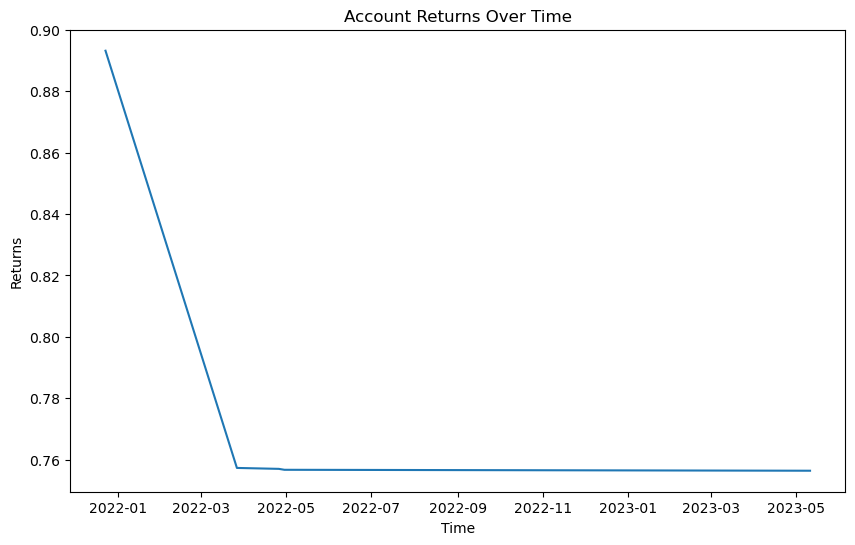

In [61]:
import matplotlib.pyplot as plt

# Set the plot size
plt.figure(figsize=(10,6))

# Plot the account balance column
plt.plot(dfr.buydates, dfr.commulative_returns)

# Add labels to the plot
plt.title('Account Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Returns')

# Display the plot
plt.show()

# Set Final Bot Parameters

In [20]:
# please put this bot parameters here

ticker = "BTCUSDT"
timeframe = "15m"
usdt_amount = 15

takeLong = True 
takeShort = True

mult = 1 # TP R:R MULTIPLYER                           ----> TO BE OPTIMIZED
risk = 15.0 # IF STOPLOSS > ?%  DONT ENTER!            ----> TO BE OPTIMIZED
HL = 20 # rolling high lows                            ----> TO BE OPTIMIZED